# Analyzing CIA Factbook Data Using SQLite & Python
In this project, we'll work with data from the __[CIA World Factbook](https://www.cia.gov/library/publications/the-world-factbook/)__, a compendium of statistics about all of the countries on Earth. You can download the SQLite database, factbook.db, __[from this GitHub repo](https://github.com/factbook/factbook.sql/releases)__.
We'll explore the Python SQLite workflow to explore, analyze, and visualize data from this database.

In [17]:
#import sql3, pandas and connect to the database
import sqlite3
import pandas as pd
conn = sqlite3.connect("factbook.db")

In [18]:
#the SQL query to look at the tables in the database
q1 = "select * from sqlite_master where type='table';"
pd.read_sql_query(q1,conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."


Let's begin exploring the data, we can use pd.read_sql_query to see what the first table looks like

In [19]:
q2 = "select * from facts"
data = pd.read_sql_query(q2, conn)
data.head()

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230.0,652230.0,0.0,32564342.0,2.32,38.57,13.89,1.51
1,2,al,Albania,28748.0,27398.0,1350.0,3029278.0,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741.0,2381741.0,0.0,39542166.0,1.84,23.67,4.31,0.92
3,4,an,Andorra,468.0,468.0,0.0,85580.0,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700.0,1246700.0,0.0,19625353.0,2.78,38.78,11.49,0.46


Let's see what the maximum and the minimum population is and then we'll identify the country name. If they are outliers, we should probably remove it from the table.

In [20]:
q3 = "select MIN(population), MAX(population), MIN(population_growth), MAX(population_growth) from facts"
data = pd.read_sql_query(q3, conn)
data.head()

,MIN(population),MAX(population),MIN(population_growth),MAX(population_growth)
0,0,7256490011,0.0,4.02


In [21]:
q4 = "select * from facts where population == (select MIN(population) from facts);"
data = pd.read_sql_query(q4, conn)
data.head()


,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,250,ay,Antarctica,None,280000,None,0,None,None,None,None


In [22]:
q5 = "select * from facts where population == (select MAX(population) from facts);"
data = pd.read_sql_query(q5, conn)
data.head()

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None


It doesn't make much sense to include Antarctica and the entire world as a part of our data analysis, we should definitely exlude this from our analysis.

We can write a SQL query along with subqueries to exlude the min and max population from the data.

In [23]:
q6 = "select population, population_growth, birth_rate, death_rate from facts where population != (select MIN(population) from facts) and population != (select MAX(population) from facts);"
data = pd.read_sql_query(q6, conn)
data.head()

,population,population_growth,birth_rate,death_rate
0,32564342,2.32,38.57,13.89
1,3029278,0.30,12.92,6.58
2,39542166,1.84,23.67,4.31
3,85580,0.12,8.13,6.96
4,19625353,2.78,38.78,11.49


Now that we have a dataframe, we can use the pd.Dataframe.hist() method to generate histograms for all the columns.

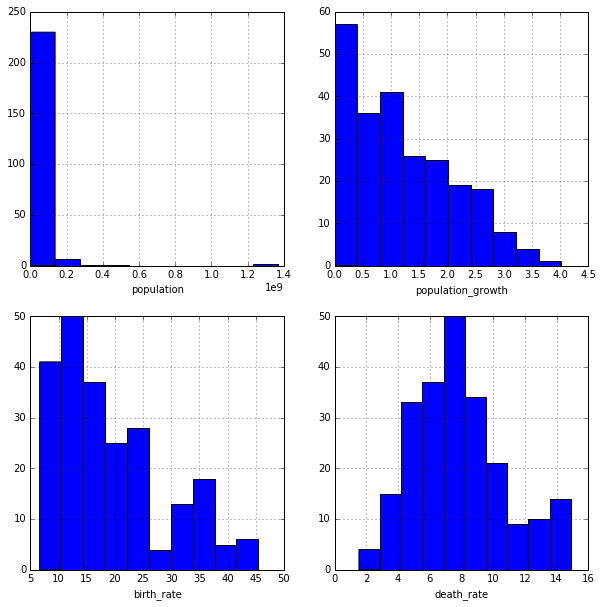

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

data["population"].hist(ax=ax1)
ax1.set_xlabel("population")
data["population_growth"].hist(ax=ax2)
ax2.set_xlabel("population_growth")
data["birth_rate"].hist(ax=ax3)
ax3.set_xlabel("birth_rate")
data["death_rate"].hist(ax=ax4)
ax4.set_xlabel("death_rate")

plt.show()

The birth_rate and population growth plot both show a right-skewed distribution, This makes sense as birth rate and population growth are directly related. The death_rate plot shows a normal distribution, almost a double peaked distribution. The population plot is a bit hard to read due to outliers.

Next we are interested to see what city has the highest population density

In [25]:
q7 = "select name, CAST(population as float)/CAST(area as float) density from facts where population != (select MIN(population) from facts) and population != (select MAX(population) from facts) order by density desc" 
data = pd.read_sql_query(q7, conn)
data.head()

,name,density
0,Macau,21168.964286
1,Monaco,15267.500000
2,Singapore,8141.279770
3,Hong Kong,6445.041516
4,Gaza Strip,5191.819444


Looks like Macau has the highest population density in the world, not too surprising because Macau is a tourist heavy town with tons of casinos.

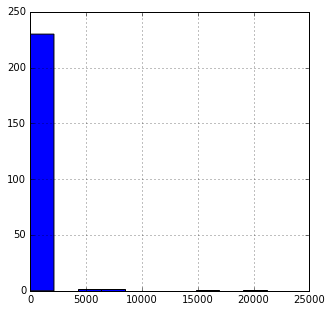

In [27]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

data['density'].hist()

plt.show()

Again there are several outliers making the data hard to read, let's limit the histogram and increase the number of bins.

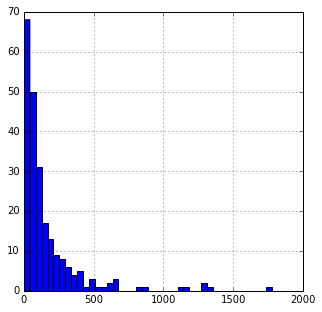

In [28]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

data['density'].hist(bins=500)
ax.set_xlim(0, 2000)
plt.show()

This table includes cities along with countries. The cities will obviously have way higher density than the countries. So plotting them both together in one histogram doesn't make much sense

This explains why the population histogram we did earlier showed a similar trend.